In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from aeon.datasets import load_classification
import numpy as np
import pandas as pd
import torch
import random
import csv
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product
from einops import rearrange

import models.models_original as models_original
import models.models_3d_atomics as new_models
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection

gpu_id = int(subprocess.check_output('nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader | nl -v 0 | sort -nrk 2 | cut -f 1 | head -n 1 | xargs', shell=True, text=True))
device = torch.device(f'cuda:{gpu_id}') if torch.cuda.is_available else torch.device('cpu')
print("current device", device)

current device cuda:14


In [2]:
X, y = load_classification("Tiselac", extract_path="/workdir/data")
print(" Shape of X = ", X.shape, type(X), X.dtype)
print(" Shape of y = ", y.shape, type(y), y.dtype)
y = y.astype(int)
display(y)


 Shape of X =  (99687, 10, 23) <class 'numpy.ndarray'> float64
 Shape of y =  (99687,) <class 'numpy.ndarray'> <U1


array([6, 1, 6, ..., 3, 4, 5])

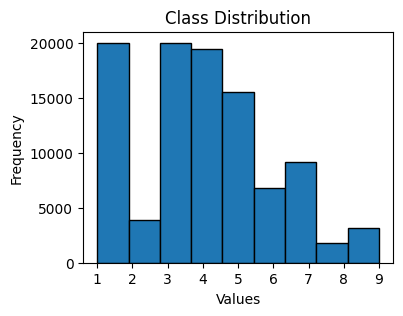

In [3]:
plt.figure(figsize=(4, 3))
plt.hist(y, bins=len(np.unique(y)), edgecolor='black')
plt.xticks(np.unique(y))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

In [4]:
def preprocess_data(X_time, _y, batch_size = 512, random_state = 1):
    # X
    X_time = rearrange(X_time, "b v t -> b t v")
    
    X_ind = ~np.isnan(X_time)
    X_time = np.nan_to_num(X_time, nan=0.0)
    
    # Target
    _y = _y - 1
    y_unique = np.unique(_y)
    num_classes = len(y_unique)
    
    
    # Class weights
    weights = compute_class_weight(class_weight='balanced', classes=y_unique, y=_y)
    weights = torch.Tensor(weights).to(device)
    
    
    # Split
    X_time_train, X_time_test, X_ind_train, X_ind_test, y_train, y_test = train_test_split(X_time, X_ind, _y, test_size = 0.40, random_state = random_state, stratify = _y)
    X_time_test, X_time_val, X_ind_test, X_ind_val, y_test, y_val = train_test_split(X_time_test, X_ind_test, y_test, test_size = 0.50, random_state = random_state, stratify = y_test)


    # Normalize
    X_time_train, X_time_val, X_time_test = normalize_across_time(X_time_train, X_time_val, X_time_test, X_time.shape[2])
    
    
    # Datasets
    X_time_train = torch.tensor(X_time_train, dtype=torch.float32)
    X_ind_train = torch.tensor(X_ind_train, dtype=torch.float32)
    y_train = torch.tensor(y_train)

    X_time_val = torch.tensor(X_time_val, dtype=torch.float32)
    X_ind_val = torch.tensor(X_ind_val, dtype=torch.float32)
    y_val = torch.tensor(y_val)

    X_time_test = torch.tensor(X_time_test, dtype=torch.float32)
    X_ind_test = torch.tensor(X_ind_test, dtype=torch.float32)
    y_test = torch.tensor(y_test)


    # Dataloaders
    train_dataset = TensorDataset(X_time_train, X_ind_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)

    val_dataset = TensorDataset(X_time_val, X_ind_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=4)

    test_dataset = TensorDataset(X_time_test, X_ind_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=4)
    
    
    return train_loader, val_loader, test_loader, weights, num_classes


def normalize_across_time(X_train, X_val, X_test, n_variables):
    # scalerX=StandardScaler(with_std=False)
    scalerX=StandardScaler()
    
    # N x T x V => N*T x V
    X_train_reshaped = X_train.reshape(-1, n_variables)
    X_val_reshaped = X_val.reshape(-1, n_variables)
    X_test_reshaped = X_test.reshape(-1, n_variables)

    nX_train = scalerX.fit_transform(X_train_reshaped)
    nX_val = scalerX.transform(X_val_reshaped)
    nX_test = scalerX.transform(X_test_reshaped)
    
    # revert shape
    nX_train = nX_train.reshape(X_train.shape)
    nX_val = nX_val.reshape(X_val.shape)
    nX_test = nX_test.reshape(X_test.shape)
    
    return nX_train, nX_val, nX_test


In [5]:
train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, y)

print(class_weights, num_classes)

for batch in train_loader:
    [print(t.shape) for t in batch]
    break

len(train_loader)

tensor([0.5538, 2.8525, 0.5538, 0.5710, 0.7132, 1.6248, 1.2057, 6.3149, 3.5524],
       device='cuda:14') 9
torch.Size([512, 23, 10])
torch.Size([512, 23, 10])
torch.Size([512])


117

In [6]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_metrics(history, n_concepts_list):
    plt.plot(history[:, 0], history[:, 2], label=f'AUC')
    plt.plot(history[:, 0], history[:, 3], label=f'ACC')
    plt.plot(history[:, 0], history[:, 4], label=f'F1')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title('Plot of Concepts vs Criteria')
    plt.xticks(n_concepts_list)

    plt.legend()
    plt.show()

def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "auc", "acc", "f1"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["auc"], label='AUC')
    plt.plot(mean_atomics.index, mean_atomics["acc"], label='ACC')
    plt.plot(mean_atomics.index, mean_atomics["f1"], label='F1')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["auc"], label='AUC')
    plt.plot(mean_concepts.index, mean_concepts["acc"], label='ACC')
    plt.plot(mean_concepts.index, mean_concepts["f1"], label='F1')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()


In [7]:
def initializeModel(n_concepts, static_dim, changing_dim, seq_len, output_dim, 
                    use_indicators, use_fixes, use_only_last_timestep, top_k=''):
    model = models_original.CBM(static_dim = static_dim, 
                                changing_dim = changing_dim, 
                                seq_len = seq_len,
                                num_concepts = n_concepts,
                                use_indicators = use_indicators,
                                use_fixes = use_fixes,
                                use_only_last_timestep = use_only_last_timestep,
                                use_grad_norm = False,
                                noise_std = False,
                                use_multiplicative_interactions = False,
                                use_summaries = True,
                                opt_lr = 1e-3,
                                opt_weight_decay = 1e-5,
                                l1_lambda=1e-3,
                                cos_sim_lambda=1e-2,
                                output_dim = output_dim,
                                top_k=top_k,
                                device = device
                                )
    model = model.to(device)
    return model

def initializeModel_with_atomics(n_atomics, n_concepts, static_dim, changing_dim, seq_len, output_dim, 
                                 use_summaries_for_atomics, use_indicators, use_fixes, top_k=''):
    model = new_models.CBM(static_dim = static_dim, 
                            changing_dim = changing_dim, 
                            seq_len = seq_len,
                            num_concepts = n_concepts,
                            num_atomics= n_atomics,
                            use_summaries_for_atomics = use_summaries_for_atomics,
                            use_indicators = use_indicators,
                            use_fixes = use_fixes,
                            use_grad_norm = False,
                            noise_std = False,
                            use_summaries = True,
                            opt_lr = 1e-3,
                            opt_weight_decay = 1e-5,
                            l1_lambda=1e-3,
                            cos_sim_lambda=1e-2,
                            output_dim = output_dim,
                            top_k=top_k,
                            device = device
                            )
    model = model.to(device)
    return model


In [8]:
auroc_metric = AUROC(task="multiclass", num_classes=num_classes).to(device)
accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_metric = F1Score(task="multiclass", num_classes=num_classes).to(device)
conf_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes).to(device)

seq_len = X.shape[2]
changing_dim = X.shape[1]
static_dim = 0

print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)


10 0 23


## Original

In [9]:
config_original = {
    "n_concepts": [4, 20],
    # "use_summaries": [True, False],
    "use_indicators": [True, False],
    "use_fixes": [False, True],
    "use_only_last_timestep": [True, False],
    # "use_grad_norm": [False, "FULL", "COMPONENT_WISE"],
}

all_config_permutations_og = list(product(*config_original.values()))
all_config_permutations_og = [dict(zip(config_original.keys(), permutation)) for permutation in all_config_permutations_og]
print(len(all_config_permutations_og))
# all_config_permutations_og

16


In [10]:
experiment_folder = "/workdir/optimal-summaries-public/_models/tiselac/original/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_original.keys()]) + "seed_{seed}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [11]:
histories_original = []

for i, config in enumerate(all_config_permutations_og):
    print(i, config)
    
    train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, y, random_state = random_seed)
    
    model = initializeModel(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=num_classes)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)
    
    model.eval()
    with torch.inference_mode():
        for batch in test_loader:
            *data, yb = extract_to(batch, device)
            probs = model(*data)
            
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            # conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        # plt.show()
        auroc_metric.reset()
        accuracy_metric.reset()
        # conf_matrix.reset()
        f1_metric.reset()
    
    history = ["original", i, model.val_losses[-1], auc, acc, f1]
    print(history)
    histories_original.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
histories_original = np.array(histories_original)
histories_original.shape


0 {'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_True_use_fixes_False_use_only_last_timestep_True_seed_1.pt
['original', 0, 0.8612943291664124, 0.9575191140174866, 0.7556302547454834, 0.7556302547454834]
1 {'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_True_use_fixes_False_use_only_last_timestep_False_seed_1.pt
['original', 1, 0.8624430298805237, 0.9605675935745239, 0.7633044123649597, 0.7633044123649597]
2 {'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_True_use_fixes_True_use_only_last_timestep_True_seed_1.pt
['original', 2, 0.8618311285972595, 0.9564356207847595, 0.7560816407203674, 0.7560816407203674]
3 {'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_True_use_fixes_True_use_only_last_timestep_False_seed_1.pt
['original', 3, 0.8132157921791077, 0.9653369188308716, 0.7859758138656616, 0.7859758138656616]
4 {'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_False_use_fixes_False_use_only_last_timestep_True_seed_1.pt
['original', 4, 0.8804569840431213, 0.9541173577308655, 0.7598936557769775, 0.7598936557769775]
5 {'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_False_use_fixes_False_use_only_last_timestep_False_seed_1.pt
['original', 5, 0.818749725818634, 0.9632485508918762, 0.7759442329406738, 0.7759442329406738]
6 {'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_False_use_fixes_True_use_only_last_timestep_True_seed_1.pt
['original', 6, 0.8865777850151062, 0.9546580910682678, 0.7607964873313904, 0.7607964873313904]
7 {'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_4_use_indicators_False_use_fixes_True_use_only_last_timestep_False_seed_1.pt
['original', 7, 0.8115879893302917, 0.9639762043952942, 0.7788032293319702, 0.7788032293319702]
8 {'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_True_use_fixes_False_use_only_last_timestep_True_seed_1.pt
['original', 8, 0.7947948575019836, 0.966227650642395, 0.7754426598548889, 0.7754426598548889]
9 {'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_True_use_fixes_False_use_only_last_timestep_False_seed_1.pt
['original', 9, 0.7679147124290466, 0.971734344959259, 0.8073431253433228, 0.8073431253433228]
10 {'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_True_use_fixes_True_use_only_last_timestep_True_seed_1.pt
['original', 10, 0.7958378791809082, 0.9656384587287903, 0.7744395136833191, 0.7744395136833191]
11 {'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_True_use_fixes_True_use_only_last_timestep_False_seed_1.pt
['original', 11, 0.784415602684021, 0.9715251922607422, 0.8082961440086365, 0.8082961440086365]
12 {'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_False_use_fixes_False_use_only_last_timestep_True_seed_1.pt
['original', 12, 0.8208258748054504, 0.9638412594795227, 0.7818628549575806, 0.7818628549575806]
13 {'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_False_use_fixes_False_use_only_last_timestep_False_seed_1.pt
['original', 13, 0.7255213856697083, 0.9737067818641663, 0.8070923686027527, 0.8070923686027527]
14 {'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_only_last_timestep': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_False_use_fixes_True_use_only_last_timestep_True_seed_1.pt
['original', 14, 0.8173299431800842, 0.9639744162559509, 0.7834177613258362, 0.7834177613258362]
15 {'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_only_last_timestep': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/original/n_concepts_20_use_indicators_False_use_fixes_True_use_only_last_timestep_False_seed_1.pt
['original', 15, 0.7327864766120911, 0.9741116762161255, 0.815117597579956, 0.815117597579956]


(16, 6)

In [12]:
# plot
# plot_metrics(histories_original, n_concepts_list)


## Atomics

In [13]:
config_atomics = {
    "n_atomics": [10, 30], # 30
    "n_concepts": [4, 20], # 20
    "use_indicators": [True, False],
    "use_fixes": [False, True],
    "use_summaries_for_atomics": [True, False],
    # "use_grad_norm": [False, "FULL", "COMPONENT_WISE"],
}

all_config_permutations_atomics = list(product(*config_atomics.values()))
all_config_permutations_atomics = [dict(zip(config_atomics.keys(), permutation)) for permutation in all_config_permutations_atomics]
print(len(all_config_permutations_atomics))
# all_config_permutations_atomics

32


In [14]:
experiment_folder = "/workdir/optimal-summaries-public/_models/tiselac/atomics/"
model_path = experiment_folder + "".join([f"{key}_{{{key}}}_" for key in config_atomics.keys()]) + "seed_{seed}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

In [15]:
history_atomics = []

for i, config in enumerate(all_config_permutations_atomics):
    print(i, config)
    
    train_loader, val_loader, test_loader, class_weights, num_classes = preprocess_data(X, y, random_state=random_seed)#, batch_size=8)
    
    model = initializeModel_with_atomics(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim = num_classes)
    model.fit(train_loader, val_loader, p_weight=class_weights.to(device), save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)
    
    model.eval()
    with torch.inference_mode():
        for batch in test_loader:
            X_time, X_ind, X_static, yb = extract_to(batch, device)
            probs = model(X_time, X_ind, X_static)
            
            auc = auroc_metric(probs, yb).item()
            acc = accuracy_metric(probs, yb).item()
            f1 = f1_metric(probs, yb).item()
            # conf_matrix(probs, yb)
        auc = auroc_metric.compute().item()
        acc = accuracy_metric.compute().item()
        f1 = f1_metric.compute().item()
        # conf_matrix.plot()
        # plt.show()
        auroc_metric.reset()
        accuracy_metric.reset()
        # conf_matrix.reset()
        f1_metric.reset()

    history = ["atomics", i, model.val_losses[-1], auc, acc, f1]
    print(history)
    history_atomics.append(np.array(history))
    
    # plot_losses(model.train_losses, model.val_losses)
    del model
    gc.collect()
    torch.cuda.empty_cache()

    
history_atomics = np.array(history_atomics)
history_atomics.shape


0 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 0, 0.8447052836418152, 0.9637842178344727, 0.7725836634635925, 0.7725836634635925]
1 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 1, 0.8603818416595459, 0.9576316475868225, 0.7562822699546814, 0.7562822699546814]
2 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 2, 0.8844080567359924, 0.9595625400543213, 0.7554797530174255, 0.7554797530174255]
3 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_True_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 3, 0.8286914825439453, 0.9618373513221741, 0.774941086769104, 0.774941086769104]
4 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_False_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 4, 0.8682188987731934, 0.9608091711997986, 0.7686211466789246, 0.7686211466789246]
5 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_False_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 5, 0.8910166621208191, 0.9551876783370972, 0.7521191835403442, 0.7521191835403442]
6 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_False_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 6, 0.8918626308441162, 0.9574487805366516, 0.7655113339424133, 0.7655113339424133]
7 {'n_atomics': 10, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_4_use_indicators_False_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 7, 0.8887022733688354, 0.9532867074012756, 0.7594422698020935, 0.7594422698020935]
8 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_True_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 8, 0.8047075271606445, 0.9686480760574341, 0.7908411622047424, 0.7908411622047424]
9 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_True_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 9, 0.7929606437683105, 0.9669490456581116, 0.779906690120697, 0.779906690120697]
10 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_True_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 10, 0.8137273192405701, 0.9675341844558716, 0.7790038585662842, 0.7790038585662842]
11 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_True_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 11, 0.7757052779197693, 0.9701511859893799, 0.801976203918457, 0.801976203918457]
12 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_False_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 12, 0.8212252259254456, 0.9664768576622009, 0.7822139859199524, 0.7822139859199524]
13 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_False_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 13, 0.7920759320259094, 0.968039333820343, 0.7943522334098816, 0.7943522334098816]
14 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_False_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 14, 0.8253666758537292, 0.9657369256019592, 0.7801575064659119, 0.7801575064659119]
15 {'n_atomics': 10, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_10_n_concepts_20_use_indicators_False_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 15, 0.8037489652633667, 0.9647741317749023, 0.7787531018257141, 0.7787531018257141]
16 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_True_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 16, 0.8668138980865479, 0.9615947008132935, 0.7671164274215698, 0.7671164274215698]
17 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_True_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 17, 0.8815483450889587, 0.9571369886398315, 0.7624015808105469, 0.7624015808105469]
18 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_True_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 18, 0.8607848286628723, 0.9624918699264526, 0.7698249220848083, 0.7698249220848083]
19 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_True_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 19, 0.8915258646011353, 0.9557878971099854, 0.7519185543060303, 0.7519185543060303]
20 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_False_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 20, 0.9066334962844849, 0.9586421251296997, 0.7592917680740356, 0.7592917680740356]
21 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_False_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 21, 0.9557990431785583, 0.9563435316085815, 0.757837176322937, 0.757837176322937]
22 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_False_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 22, 0.9032139182090759, 0.9620363712310791, 0.7635050415992737, 0.7635050415992737]
23 {'n_atomics': 30, 'n_concepts': 4, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_4_use_indicators_False_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 23, 0.9883100390434265, 0.9523550868034363, 0.7431408762931824, 0.7431408762931824]
24 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_True_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 24, 0.8115636110305786, 0.9693948030471802, 0.797662615776062, 0.797662615776062]
25 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_True_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 25, 0.8148693442344666, 0.9658177495002747, 0.7852234244346619, 0.7852234244346619]
26 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_True_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 26, 0.8137856125831604, 0.9686681032180786, 0.7901389598846436, 0.7901389598846436]
27 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': True, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_True_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 27, 0.7841296195983887, 0.9699182510375977, 0.7922957539558411, 0.7922957539558411]
28 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_False_use_fixes_False_use_summaries_for_atomics_True_seed_1.pt
['atomics', 28, 0.844871461391449, 0.96774822473526, 0.793048083782196, 0.793048083782196]
29 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': False, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_False_use_fixes_False_use_summaries_for_atomics_False_seed_1.pt
['atomics', 29, 0.8785293102264404, 0.9673466086387634, 0.7976124882698059, 0.7976124882698059]
30 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': True}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_False_use_fixes_True_use_summaries_for_atomics_True_seed_1.pt
['atomics', 30, 0.8519159555435181, 0.9671088457107544, 0.7897878289222717, 0.7897878289222717]
31 {'n_atomics': 30, 'n_concepts': 20, 'use_indicators': False, 'use_fixes': True, 'use_summaries_for_atomics': False}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/tiselac/atomics/n_atomics_30_n_concepts_20_use_indicators_False_use_fixes_True_use_summaries_for_atomics_False_seed_1.pt
['atomics', 31, 0.8906210064888, 0.9656895399093628, 0.7911421060562134, 0.7911421060562134]


(32, 6)

In [16]:
columns=["type", "config", "val_loss", "auc", "acc", "f1"]
dtypes = {'type': str, 'config': int, 'val_loss': float, 'auc': float, 'acc': float, 'f1': float}

df_og = pd.DataFrame(histories_original, columns=columns).astype(dtypes)
df_og = pd.concat([df_og, pd.DataFrame(all_config_permutations_og)], axis=1)

df_atomics = pd.DataFrame(history_atomics, columns=columns).astype(dtypes)
df_atomics = pd.concat([df_atomics, pd.DataFrame(all_config_permutations_atomics)], axis=1)

result_df = pd.concat([df_og, df_atomics], ignore_index=True)
# result_df

In [17]:
for col in result_df.columns[3:6]:
    baseline = result_df[(result_df['type'] == 'original') & (result_df['config'] == 0)][col].values[0]
    print(col, baseline)
    result_df[f'{col}_abs_imp'] = result_df[col] - baseline
    # result_df[f'{col}_rel_imp'] = result_df[f'{col}_abs_imp'] / baseline
# result_df

auc 0.9575191140174866
acc 0.7556302547454834
f1 0.7556302547454834


In [18]:
pd.set_option('display.max_rows', 500)
result_df.sort_values(by='acc', ascending=False)
# atomics: atomics, concepts, use_indicators, use_fixes, output_dim, use_summaries_for_atomics
# original: concepts, use_indicators, use_fixes, output_dim, use_only_last_timestep


,type,config,val_loss,auc,acc,f1,n_concepts,use_indicators,use_fixes,use_only_last_timestep,n_atomics,use_summaries_for_atomics,auc_abs_imp,acc_abs_imp,f1_abs_imp
15,original,15,0.732786,0.974112,0.815118,0.815118,20,False,True,False,NaN,NaN,0.016593,0.059487,0.059487
11,original,11,0.784416,0.971525,0.808296,0.808296,20,True,True,False,NaN,NaN,0.014006,0.052666,0.052666
9,original,9,0.767915,0.971734,0.807343,0.807343,20,True,False,False,NaN,NaN,0.014215,0.051713,0.051713
13,original,13,0.725521,0.973707,0.807092,0.807092,20,False,False,False,NaN,NaN,0.016188,0.051462,0.051462
27,atomics,11,0.775705,0.970151,0.801976,0.801976,20,True,True,NaN,10.0,False,0.012632,0.046346,0.046346
40,atomics,24,0.811564,0.969395,0.797663,0.797663,20,True,False,NaN,30.0,True,0.011876,0.042032,0.042032
45,atomics,29,0.878529,0.967347,0.797612,0.797612,20,False,False,NaN,30.0,False,0.009827,0.041982,0.041982
29,atomics,13,0.792076,0.968039,0.794352,0.794352,20,False,False,NaN,10.0,False,0.010520,0.038722,0.038722
44,atomics,28,0.844871,0.967748,0.793048,0.793048,20,False,False,NaN,30.0,True,0.010229,0.037418,0.037418
43,atomics,27,0.784130,0.969918,0.792296,0.792296,20,True,True,NaN,30.0,False,0.012399,0.036665,0.036665


In [19]:
for key in sorted(set(list(all_config_permutations_og[0].keys()) + list(all_config_permutations_atomics[0].keys()))):
    display(result_df.groupby(["type", key])[["auc", "acc", "f1"]].mean())

display(result_df.groupby("type")[["auc", "acc", "f1"]].mean())

auc       acc        f1
type    n_atomics                              
atomics 10.0       0.962991  0.774512  0.774512
        30.0       0.963005  0.775747  0.775747

auc       acc        f1
type     n_concepts                              
atomics  4           0.958496  0.761251  0.761251
         20          0.967500  0.789007  0.789007
original 4           0.959482  0.767054  0.767054
         20          0.968845  0.794127  0.794127

auc       acc        f1
type     use_fixes                              
atomics  False      0.963222  0.776070  0.776070
         True       0.962774  0.774189  0.774189
original False      0.963870  0.778314  0.778314
         True       0.964457  0.782866  0.782866

auc       acc        f1
type     use_indicators                              
atomics  False           0.961814  0.773534  0.773534
         True            0.964182  0.776725  0.776725
original False           0.963954  0.782866  0.782866
         True            0.964373  0.778314  0.778314

auc       acc        f1
type     use_only_last_timestep                              
original False                   0.968026  0.792735  0.792735
         True                    0.960301  0.768446  0.768446

auc       acc        f1
type    use_summaries_for_atomics                              
atomics False                      0.961766  0.773709  0.773709
        True                       0.964230  0.776549  0.776549

,auc,acc,f1
type,,,
atomics,0.962998,0.775129,0.775129
original,0.964164,0.780590,0.780590


## Optimization

In [ ]:
# feature weights
n_concepts = 4

model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes)
model.fit(train_loader, val_loader, class_weights, model_path.format(n_concepts), 1000)

for batch_idx, (Xb, yb) in enumerate(test_loader):
    Xb, yb = Xb.to(device), yb.to(device)
    probs = model(Xb)
    
    auc = auroc_metric(probs, yb).item()
    acc = accuracy_metric(probs, yb).item()
    conf_matrix(probs, yb)
auc = auroc_metric.compute().item()
acc = accuracy_metric.compute().item()
conf_matrix.plot()
auroc_metric.reset()
accuracy_metric.reset()
conf_matrix.reset()

print("AUC", auc)
print("ACC", acc)

In [ ]:
for name, param in model.named_parameters():
    if "bottleneck.weight" in name:
        bottleneck_weights = param
feature_weights = bottleneck_weights.cpu().detach().numpy()

feature_weights.shape

In [ ]:
# visualize weight magnitudes
for c in range(n_concepts):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    inds = np.argsort(-np.abs(feature_weights[c]))[:100]
    ax.bar(np.arange(1,101),np.abs(feature_weights[c])[inds])
    ax.set_xlabel("Top 100 features")
    ax.set_ylabel("abs value of feature coefficient")
    plt.show()


In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(feature_weights), axis=-1)*0.90
sum90p.shape


In [ ]:
# get top K indizes
top_k_inds = []
for c in range(n_concepts):
    topkinds_conc = []
    curr_sum = 0
    inds = np.argsort(-np.abs(feature_weights[c])) #desc
    sorted_weights = feature_weights[c][inds]
    
    for ind, weight in zip(inds, sorted_weights):
        curr_sum += abs(weight)
        if curr_sum <= sum90p[c]:
            topkinds_conc.append(ind)
        else:
            break
    
    # if selects less than 10, choose 10 best
    if len(topkinds_conc) < 10:
        topkinds_conc = np.argsort(-np.abs(feature_weights[c]))[:10].tolist()
    
    top_k_inds.append(topkinds_conc)

top_k_inds

In [ ]:
# write top k inds to csv
filename = experiment_folder + "top-k/top_k_inds_c{}.csv".format(n_concepts)

directory = os.path.dirname(filename)
if not os.path.exists(directory):
    os.makedirs(directory)

# writing to csv file 
with open(filename, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    # writing the data rows 
    csvwriter.writerows(top_k_inds)


In [ ]:
V = 13 + 1
T = seq_len + 1
print(T)
vars_ = [i for i in range(1,V)] + [str(i) + "_ind" for i in range(1,V)]
print(len(vars_))
data_cols = [["feat_{}_time_{}".format(v, t) for v in vars_] for t in range(1, T)]
flattened_data_cols = [col for sublist in data_cols for col in sublist]
print(len(flattened_data_cols))
flattened_data_cols

In [ ]:

for c, _list in enumerate(top_k_inds):
    for ind in _list:
        name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, int(ind))
        print(f"Concept {c}: ID {ind}, Feature {name}, Summary {summary}")


In [ ]:
greedy_results = greedy_forward_selection(auroc_metric, test_loader, top_k_inds, model, track_metrics={"acc": accuracy_metric})
greedy_results.head(10)

In [ ]:
top_k_csv_file = experiment_folder + "top-k/bottleneck_r{}_c{}_topkinds.csv".format(random_seed, n_concepts)

# writing to csv file
with open(top_k_csv_file, 'w') as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(greedy_results.columns)
    # writing the data rows 
    for row in greedy_results.itertuples(index=False):
        csvwriter.writerow(list(row))


In [ ]:
sorted_ = greedy_results.sort_values(["Concept", "ID"])

for row in sorted_.itertuples(index=False):
    name, summary = getConcept(flattened_data_cols, input_dim, changing_dim, row[1])
    print(f"Concept {row[2]}: ID {row[1]}, Feature {name}, Summary {summary}")

In [ ]:
plt.plot(greedy_results["Score"], label = f"AUC {greedy_results['Score'].values[-1]:.3f}")
plt.plot(greedy_results["acc"], label = f"ACC {greedy_results['acc'].values[-1]:.3f}")

plt.xlabel('Num Concepts')
plt.ylabel('Criteria')
plt.title('Plot of Concepts vs Criteria')

plt.legend()
plt.show()


In [ ]:
top_k_csv_file = "/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/bottleneck_r1_c6_topkinds.csv"
n_concepts = 6
model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, num_classes, top_k=top_k_csv_file)
# model.fit(train_loader, val_loader, weights, model_path.format(n_concepts), 1000)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb).item()
        acc = accuracy_metric(probs, yb).item()
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()

print(auc)
print(acc)


In [ ]:
model.fit(train_loader, val_loader, class_weights, save_model_path="/workdir/optimal-summaries-public/_models/arabic/multiclass/top-k/arabic_c6_finetuned.pt", max_epochs=3000, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        probs = model(Xb)
        
        auc = auroc_metric(probs, yb)
        acc = accuracy_metric(probs, yb)
    auc = auroc_metric.compute().item()
    acc = accuracy_metric.compute().item()
    auroc_metric.reset()
    accuracy_metric.reset()
    
print(auc)
print(acc)


In [ ]:

plt.plot(model.val_losses)
plt.show()